In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_recall_curve, 
    precision_score, recall_score, f1_score, confusion_matrix, roc_curve, average_precision_score
)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from tqdm import tqdm


import json
import yaml
import random
import wandb
import ast
import optuna

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Load

In [3]:
def load_ptb_data():
    # PTB-XL 데이터셋 로드 및 전처리
    df_ptb = pd.read_csv('./ptb_xl_data/ptbxl_database.csv', index_col='ecg_id')
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: ast.literal_eval(x))
    df_ptb.scp_codes = df_ptb.scp_codes.apply(lambda x: list(x.keys()))
    df_ptb['label'] = df_ptb.scp_codes.apply(lambda arr: 1 if 'AFIB' in arr else 0)
    # 총 21799개 중 AFIB 라벨이 있는 샘플은 1514개로 6.95%에 해당, 샘플 불균형 존재

    labels = df_ptb['label'].values
    lead1_signals = np.load('./custom_file/annie_ptb_xl_lead1.npy')


    # 데이터 정규화 (전체)
    lead1_signals_normalized = (lead1_signals - lead1_signals.mean()) / (lead1_signals.std()+1e-7)

    # 데이터셋을 텐서로 변환
    X = torch.Tensor(lead1_signals_normalized)
    y = torch.Tensor(labels).long()

    # 데이터 분할 (훈련:검증:테스트 = 8:1:1)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # 채널 수를 1로 추가
    X_train = X_train.unsqueeze(1)
    X_val = X_val.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

    return X_train, X_val, X_test, y_train, y_val, y_test



def create_dataloaders(batch_size=64):
    # DataLoader 생성, batch_size를 변경하려면 함수 호출 시 파라미터 변경
    X_train, X_val, X_test, y_train, y_val, y_test = load_ptb_data()

    # DataLoader 생성
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, val_loader, test_loader



def load_sph_data(batch_size=64):
    # SPH 데이터 로드 및 전처리
    df_sph = pd.read_csv("./sph_data/metadata.csv", index_col='ECG_ID')
    # 'AHA_Code' 컬럼의 각 값에 대해 '50'이 포함되어 있는지 확인하고, 'label' 컬럼 생성
    def check_contains_50(code):
        numbers = code.replace(' ', '').replace('+', ';').split(';')
        return '50' in numbers
    # 25770 개 중 675개. 2.62% 샘플 불균형

    df_sph['label'] = df_sph['AHA_Code'].apply(check_contains_50).astype(int)
    
    sph_labels = df_sph['label'].values

    sph_signals = np.load('./custom_file/annie_sph_lead1.npy')
    sph_signals_float = sph_signals.astype(np.float32)
    mean = np.mean(sph_signals_float)
    std = np.std(sph_signals_float)
    sph_signals_normalized = (sph_signals_float - mean) / (std + 1e-7)


    # 데이터 정규화 및 텐서 변환
    X_sph = torch.Tensor(sph_signals_normalized)
    y_sph = torch.Tensor(df_sph['label'].values).long()

    X_sph = X_sph.unsqueeze(1)

    sph_data = TensorDataset(X_sph, y_sph)
    sph_loader = DataLoader(sph_data, batch_size=batch_size)

    return sph_loader



# 1D CNN Modeling

In [4]:
# SimpleCNN

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=2) 
        self.pool = nn.MaxPool1d(kernel_size=5, stride=1) 
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5) 
        self.fc1 = nn.Linear(64 * 2486, 1000) 
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 1)

    def forward(self, x):
        x = self.pool(nn.functional.leaky_relu(self.conv1(x)))
        x = self.pool(nn.functional.leaky_relu(self.conv2(x)))
        x = x.view(-1, 64 * 2486)
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x



# 논문 구현 코드

class Custom1DCNN(nn.Module):
    def __init__(self):
        super(Custom1DCNN, self).__init__()

        # Convolutional Blocks
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 32, kernel_size=5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5)
        self.maxpool3 = nn.MaxPool1d(2)

        self.conv4 = nn.Conv1d(64, 64, kernel_size=5)
        self.maxpool4 = nn.MaxPool1d(2)

        self.conv5 = nn.Conv1d(64, 128, kernel_size=5)
        self.maxpool5 = nn.MaxPool1d(2)

        self.conv6 = nn.Conv1d(128, 128, kernel_size=5)
        self.maxpool6 = nn.MaxPool1d(2)

        self.dropout1 = nn.Dropout(0.3)

        self.conv7 = nn.Conv1d(128, 256, kernel_size=5)
        self.maxpool7 = nn.MaxPool1d(2)

        self.conv8 = nn.Conv1d(256, 256, kernel_size=5)
        self.maxpool8 = nn.MaxPool1d(2)

        self.dropout2 = nn.Dropout(0.3)

        self.conv9 = nn.Conv1d(256, 512, kernel_size=5)
        self.maxpool9 = nn.MaxPool1d(2)

        self.dropout3 = nn.Dropout(0.3)

        self.conv10 = nn.Conv1d(512, 512, kernel_size=5)

        # Fully Connected Blocks
        self.flatten = nn.Flatten()

        self.dense1 = nn.Linear(512, 128)
        self.batch_norm_dense1 = nn.BatchNorm1d(128)  # BatchNorm1d for Dense1
        self.dropout4 = nn.Dropout(0.3)

        self.dense2 = nn.Linear(128, 32)
        self.batch_norm_dense2 = nn.BatchNorm1d(32)  # BatchNorm1d for Dense2

        self.dense3 = nn.Linear(32, 1)
        

    def forward(self, x):
        # Convolutional Blocks
        x = self.maxpool1(self.relu(self.bn1(self.conv1(x))))
        x = self.maxpool2(self.relu(self.conv2(x)))
        x = self.maxpool3(self.relu(self.conv3(x)))
        x = self.maxpool4(self.relu(self.conv4(x)))
        x = self.maxpool5(self.relu(self.conv5(x)))
        x = self.maxpool6(self.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = self.maxpool7(self.relu(self.conv7(x)))
        x = self.maxpool8(self.relu(self.conv8(x)))
        x = self.dropout2(x)
        x = self.maxpool9(self.relu(self.conv9(x)))
        x = self.dropout3(x)
        x = self.conv10(x)

        # Fully Connected Blocks
        x = self.flatten(x)
        x = self.dropout4(self.relu(self.batch_norm_dense1(self.dense1(x))))
        x = self.relu(self.batch_norm_dense2(self.dense2(x)))
        x = self.dense3(x)

        return x

# 1D CNN + LSTM Modeling

In [21]:

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=50, stride=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=20, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=10, stride=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=10, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # 세번째 Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.dropout3 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layers
        self.dense1 = nn.Linear(32, 32)
        self.relu_dense1 = nn.ReLU()
        self.dropout_dense1 = nn.Dropout(p=0.1)

        self.dense2 = nn.Linear(32, 16)
        self.relu_dense2 = nn.ReLU()

        # Output Layer - 이중분류를 위해 출력 유닛을 1로 설정
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # x: ECG 데이터 (Batch Size, Channels, Length)
        
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.conv1(x))))
        x = self.dropout2(self.maxpool2(self.relu2(self.conv2(x))))
        x = self.dropout3(self.maxpool3(self.relu3(self.conv3(x))))

        # print(x.shape) # (32, 16, 591)

        # LSTM Layer - LSTM은 추가적인 차원을 요구하기 때문에 차원 조정이 필요합니다.
        x = x.permute(0, 2, 1) # (Batch Size, Sequence Length, Features)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :]) # 마지막 시퀀스의 출력만 사용

        # Dense Layers
        x = self.dropout_dense1(self.relu_dense1(self.dense1(x)))
        x = self.relu_dense2(self.dense2(x))

        # Output Layer - 시그모이드 활성화 함수를 사용하여 0과 1 사이의 값을 출력
        x = torch.sigmoid(self.output(x))
        return x


In [22]:
class SimplifiedCNNLSTMModel(nn.Module):
    def __init__(self):
        super(SimplifiedCNNLSTMModel, self).__init__()
        
        # 첫번째 Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.1)

        # 두번째 Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(p=0.1)

        # LSTM Block
        self.lstm = nn.LSTM(input_size=16, hidden_size=16, batch_first=True)
        self.dropout_lstm = nn.Dropout(p=0.1)

        # Dense Layer
        self.dense = nn.Linear(16, 16)
        self.relu_dense = nn.ReLU()

        # Output Layer
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        # Convolutional Blocks
        x = self.dropout1(self.maxpool1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.maxpool2(self.relu2(self.bn2(self.conv2(x)))))

        # LSTM Layer
        x = x.permute(0, 2, 1)
        x, (hn, cn) = self.lstm(x)
        x = self.dropout_lstm(x[:, -1, :])

        # Dense Layer
        x = self.relu_dense(self.dense(x))

        # Output Layer
        x = torch.sigmoid(self.output(x))
        return x


# Training

In [6]:
# 사용자 정의 모듈을 임포트합니다.
from annie_data_prep import create_dataloaders, load_sph_data
from annie_cnn_model import SimpleCNN, Custom1DCNN, Custom1DCNNWithBatchNormAndDropout
from annie_cnnlstm_model import CNNLSTMModel


## 모델 시드 고정 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU를 사용하는 경우
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    


#with open('./annie_hypprm.yaml', 'r') as file:
#    hyperparameters = yaml.load(file, Loader=yaml.FullLoader)

#learning_rate = hyperparameters['learning_rate']
#batch_size = hyperparameters['batch_size']
#num_epochs = hyperparameters['num_epochs']



learning_rate = 0.00888712339335385
batch_size = 64
num_epochs = 100


# 하이퍼파라미터 출력
print("-"*23)
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")
print("-"*23)
print(">>>>> Let's GO!!! <<<<<")
print("-"*23)

#print(f"Hidden Units: {hidden_units}")



# 모델을 GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Custom1DCNN().to(device)
# Custom1DCNNWithBatchNormAndDropout


# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=7, factor=0.1, verbose=True)



def train_model():
    # 학습 및 검증 결과 기록을 위한 사전 선언
    model_info = {}

    # 학습 및 검증 과정에서의 손실과 정확도 기록
    train_losses = []
    train_accuracies = []
    train_aurocs = []  # 훈련 데이터 AUROC 기록을 위한 리스트
    train_auprcs = []  # 훈련 데이터 AUPRC 기록을 위한 리스트
    val_losses = []
    val_accuracies = []
    val_aurocs = []
    val_auprcs = []  # AUPRC 기록을 위한 리스트 추가

    train_loader, val_loader, _ = create_dataloaders(batch_size)
    #best_auroc = float('-inf')  # 최고 AUROC 기록을 위한 초기값 설정
    best_auprc = float('-inf')  # 최고 AUPRC 기록을 위한 초기값 설정
    best_auprc_info = None  # 최고 AUPRC 값을 가진 모델의 정보를 저장할 변수


    epochs_no_improve = 0
    early_stop = False
    patience = 20

    for epoch in range(num_epochs):
        # 훈련 루프
        model.train()
        train_loss = 0.0
        train_preds, train_targets = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # 그래디언트 초기화

            # 순전파 및 역전파
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(train_targets, np.round(train_preds))
        train_auroc = roc_auc_score(train_targets, train_preds)
        train_auprc = average_precision_score(train_targets, train_preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_aurocs.append(train_auroc)
        train_auprcs.append(train_auprc)
        print(f">>> [Train] AUROC: {train_auroc:.4f} / AUPRC: {train_auprc:.4f}")



        # 검증 루프
        model.eval()
        val_loss, val_preds, val_targets = 0.0, [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), labels.float())
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_accuracy = accuracy_score(val_targets, np.round(val_preds))
        val_auroc = roc_auc_score(val_targets, val_preds)
        val_auprc = average_precision_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_aurocs.append(val_auroc)
        val_auprcs.append(val_auprc)
        print(f">>> [Valid] AUROC: {val_auroc:.4f} / AUPRC: {val_auprc:.4f}")


        # 에포크 결과 기록
        epoch_info = {
            'train_loss': train_loss,
            'valid_loss': val_loss,
            'train_accuracy': train_accuracy,  
            'valid_accuracy': val_accuracy,      
            'train_auroc': train_auroc,
            'valid_auroc': val_auroc,
            'train_auprc': train_auprc,        
            'valid_auprc': val_auprc
        }
        model_info[epoch + 1] = epoch_info


        # 스케줄러 업데이트
        scheduler.step(val_auprc)

        # Early Stopping 체크 및 모델 저장
        if val_auprc > best_auprc:
            best_auprc = val_auprc
            epochs_no_improve = 0
            best_auprc_info = epoch_info  # 최고 AUPRC 값을 갱신할 때 정보 저장
            torch.save(model.state_dict(), 'Deep_best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break
    

    # 전체 학습 과정의 결과를 JSON 파일로 저장
    with open('Deep_model_info.json', 'w') as f:
        json.dump(model_info, f, indent=4)



    # 최고 AUPRC 값을 가진 모델의 정보 출력
    print("-" * 42)
    print("<Best AUPRC Model's Performance>")
    if best_auprc_info is not None:
        items = list(best_auprc_info.items())
        for i, (key, value) in enumerate(items):
            print(f"[{key}]: {value:.4f}" + (" <- Pick It Up!" if i == len(items) - 1 else ""))



train_model()

-----------------------
Learning Rate: 0.00888712339335385
Batch Size: 64
Number of Epochs: 100
-----------------------
>>>>> Let's GO!!! <<<<<
-----------------------


Epoch 1/100 - Training: 100%|██████████| 273/273 [00:12<00:00, 21.73it/s]


>>> [Train] AUROC: 0.5390 / AUPRC: 0.0794
>>> [Valid] AUROC: 0.6010 / AUPRC: 0.1067


Epoch 2/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 37.55it/s]


>>> [Train] AUROC: 0.8484 / AUPRC: 0.3001
>>> [Valid] AUROC: 0.9541 / AUPRC: 0.4676


Epoch 3/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 37.04it/s]


>>> [Train] AUROC: 0.9488 / AUPRC: 0.5242
>>> [Valid] AUROC: 0.9763 / AUPRC: 0.6227


Epoch 4/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.95it/s]


>>> [Train] AUROC: 0.9633 / AUPRC: 0.6003
>>> [Valid] AUROC: 0.9771 / AUPRC: 0.6444


Epoch 5/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 37.27it/s]


>>> [Train] AUROC: 0.9655 / AUPRC: 0.6185
>>> [Valid] AUROC: 0.9800 / AUPRC: 0.6590


Epoch 6/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.64it/s]


>>> [Train] AUROC: 0.9656 / AUPRC: 0.6121
>>> [Valid] AUROC: 0.9832 / AUPRC: 0.7179


Epoch 7/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.53it/s]


>>> [Train] AUROC: 0.9695 / AUPRC: 0.6581
>>> [Valid] AUROC: 0.9819 / AUPRC: 0.6874


Epoch 8/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.50it/s]


>>> [Train] AUROC: 0.9704 / AUPRC: 0.6647
>>> [Valid] AUROC: 0.9821 / AUPRC: 0.6955


Epoch 9/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.14it/s]


>>> [Train] AUROC: 0.9742 / AUPRC: 0.7072
>>> [Valid] AUROC: 0.9836 / AUPRC: 0.7143


Epoch 10/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.14it/s]


>>> [Train] AUROC: 0.9769 / AUPRC: 0.7201
>>> [Valid] AUROC: 0.9819 / AUPRC: 0.7106


Epoch 11/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.36it/s]


>>> [Train] AUROC: 0.9764 / AUPRC: 0.7378
>>> [Valid] AUROC: 0.9858 / AUPRC: 0.7696


Epoch 12/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.45it/s]


>>> [Train] AUROC: 0.9775 / AUPRC: 0.7324
>>> [Valid] AUROC: 0.9880 / AUPRC: 0.8249


Epoch 13/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.48it/s]


>>> [Train] AUROC: 0.9798 / AUPRC: 0.7751
>>> [Valid] AUROC: 0.9895 / AUPRC: 0.8506


Epoch 14/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.37it/s]


>>> [Train] AUROC: 0.9818 / AUPRC: 0.7898
>>> [Valid] AUROC: 0.9852 / AUPRC: 0.8038


Epoch 15/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.45it/s]


>>> [Train] AUROC: 0.9835 / AUPRC: 0.8304
>>> [Valid] AUROC: 0.9885 / AUPRC: 0.8762


Epoch 16/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.40it/s]


>>> [Train] AUROC: 0.9825 / AUPRC: 0.8235
>>> [Valid] AUROC: 0.9853 / AUPRC: 0.8689


Epoch 17/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.11it/s]


>>> [Train] AUROC: 0.9864 / AUPRC: 0.8431
>>> [Valid] AUROC: 0.9890 / AUPRC: 0.8978


Epoch 18/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.27it/s]


>>> [Train] AUROC: 0.9852 / AUPRC: 0.8511
>>> [Valid] AUROC: 0.9904 / AUPRC: 0.8907


Epoch 19/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.87it/s]


>>> [Train] AUROC: 0.9870 / AUPRC: 0.8591
>>> [Valid] AUROC: 0.9906 / AUPRC: 0.9038


Epoch 20/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.16it/s]


>>> [Train] AUROC: 0.9870 / AUPRC: 0.8699
>>> [Valid] AUROC: 0.9901 / AUPRC: 0.9196


Epoch 21/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.10it/s]


>>> [Train] AUROC: 0.9862 / AUPRC: 0.8852
>>> [Valid] AUROC: 0.9917 / AUPRC: 0.9161


Epoch 22/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.06it/s]


>>> [Train] AUROC: 0.9889 / AUPRC: 0.8945
>>> [Valid] AUROC: 0.9924 / AUPRC: 0.9182


Epoch 23/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.51it/s]


>>> [Train] AUROC: 0.9881 / AUPRC: 0.8975
>>> [Valid] AUROC: 0.9908 / AUPRC: 0.9179


Epoch 24/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.53it/s]


>>> [Train] AUROC: 0.9897 / AUPRC: 0.9148
>>> [Valid] AUROC: 0.9882 / AUPRC: 0.9086


Epoch 25/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.60it/s]


>>> [Train] AUROC: 0.9904 / AUPRC: 0.9148
>>> [Valid] AUROC: 0.9910 / AUPRC: 0.8834


Epoch 26/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.29it/s]


>>> [Train] AUROC: 0.9900 / AUPRC: 0.9101
>>> [Valid] AUROC: 0.9917 / AUPRC: 0.9027


Epoch 27/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 35.97it/s]


>>> [Train] AUROC: 0.9908 / AUPRC: 0.9068
>>> [Valid] AUROC: 0.9862 / AUPRC: 0.8892


Epoch 28/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.44it/s]


>>> [Train] AUROC: 0.9916 / AUPRC: 0.9267
>>> [Valid] AUROC: 0.9835 / AUPRC: 0.9184
Epoch 00028: reducing learning rate of group 0 to 8.8871e-04.


Epoch 29/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.36it/s]


>>> [Train] AUROC: 0.9946 / AUPRC: 0.9476
>>> [Valid] AUROC: 0.9833 / AUPRC: 0.9189


Epoch 30/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.16it/s]


>>> [Train] AUROC: 0.9955 / AUPRC: 0.9535
>>> [Valid] AUROC: 0.9846 / AUPRC: 0.9179


Epoch 31/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.14it/s]


>>> [Train] AUROC: 0.9951 / AUPRC: 0.9530
>>> [Valid] AUROC: 0.9801 / AUPRC: 0.9154


Epoch 32/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.40it/s]


>>> [Train] AUROC: 0.9962 / AUPRC: 0.9570
>>> [Valid] AUROC: 0.9750 / AUPRC: 0.9113


Epoch 33/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.42it/s]


>>> [Train] AUROC: 0.9942 / AUPRC: 0.9557
>>> [Valid] AUROC: 0.9770 / AUPRC: 0.9158


Epoch 34/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.36it/s]


>>> [Train] AUROC: 0.9948 / AUPRC: 0.9615
>>> [Valid] AUROC: 0.9758 / AUPRC: 0.9126


Epoch 35/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.07it/s]


>>> [Train] AUROC: 0.9955 / AUPRC: 0.9600
>>> [Valid] AUROC: 0.9773 / AUPRC: 0.9127


Epoch 36/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.51it/s]


>>> [Train] AUROC: 0.9959 / AUPRC: 0.9597
>>> [Valid] AUROC: 0.9766 / AUPRC: 0.9132
Epoch 00036: reducing learning rate of group 0 to 8.8871e-05.


Epoch 37/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.50it/s]


>>> [Train] AUROC: 0.9951 / AUPRC: 0.9625
>>> [Valid] AUROC: 0.9754 / AUPRC: 0.9132


Epoch 38/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.17it/s]


>>> [Train] AUROC: 0.9957 / AUPRC: 0.9628
>>> [Valid] AUROC: 0.9756 / AUPRC: 0.9106


Epoch 39/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.08it/s]


>>> [Train] AUROC: 0.9962 / AUPRC: 0.9608
>>> [Valid] AUROC: 0.9758 / AUPRC: 0.9127


Epoch 40/100 - Training: 100%|██████████| 273/273 [00:07<00:00, 36.56it/s]


>>> [Train] AUROC: 0.9955 / AUPRC: 0.9648
>>> [Valid] AUROC: 0.9752 / AUPRC: 0.9096
Early stopping
------------------------------------------
<Best AUPRC Model's Performance>
[train_loss]: 0.0625
[valid_loss]: 0.1238
[train_accuracy]: 0.9765
[valid_accuracy]: 0.9596
[train_auroc]: 0.9870
[valid_auroc]: 0.9901
[train_auprc]: 0.8699
[valid_auprc]: 0.9196 <- Pick It Up!


## Train 결과 확인

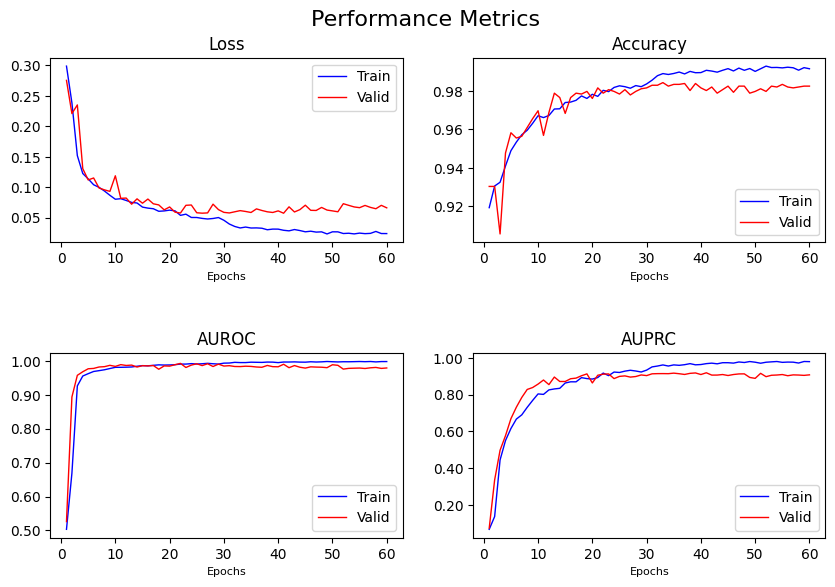

In [11]:
def plot_prediction_comparison(true_labels, predicted_labels, subplot_position):
    """
    서브플롯 위치에 실제 라벨과 예측 라벨을 비교하는 그래프를 그립니다.
    :param true_labels: 실제 라벨
    :param predicted_labels: 예측 라벨
    :param subplot_position: subplot의 위치
    """
    plt.subplot(subplot_position)
    plt.plot(true_labels, label='실제 라벨', lw=1)
    plt.plot(predicted_labels, label='예측 라벨', linestyle='--')
    plt.title('실제 라벨 vs 예측 라벨', fontsize=12)
    plt.xlabel('Sample', fontsize=8)
    plt.ylabel('Label', fontsize=8)
    plt.legend()


def plot_metric_subplot(train_metric, val_metric, metric_name, subplot_position):
    """
    서브플롯 위치에 성능 지표에 대한 그래프를 그립니다.
    :param train_metric: 훈련 데이터의 성능 지표
    :param val_metric: 검증 데이터의 성능 지표
    :param metric_name: 그래프에 표시할 성능 지표의 이름
    :param subplot_position: subplot의 위치 (예: 221, 222, 223, 224)
    """
    plt.subplot(subplot_position)
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b-', label='Train', lw=1)
    plt.plot(epochs, val_metric, 'r-', label='Valid', lw=1)
    plt.title(metric_name, fontsize=12)
    plt.xlabel('Epochs', fontsize=8)



    # Y축 눈금을 소수점 두 자리 형식으로 설정
    ax = plt.gca()
    y_vals = ax.get_yticks()
    ax.yaxis.set_major_locator(FixedLocator(y_vals))
    ax.set_yticklabels(['{:.2f}'.format(y) for y in y_vals])

    plt.legend()



# 성능 지표를 파일에서 불러오는 함수
def load_metrics(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        train_losses = [epoch_info['train_loss'] for epoch_info in data.values()]
        val_losses = [epoch_info['valid_loss'] for epoch_info in data.values()]
        train_accuracies = [epoch_info['train_accuracy'] for epoch_info in data.values()]
        val_accuracies = [epoch_info['valid_accuracy'] for epoch_info in data.values()]
        train_aurocs = [epoch_info['train_auroc'] for epoch_info in data.values()]
        val_aurocs = [epoch_info['valid_auroc'] for epoch_info in data.values()]
        train_auprcs = [epoch_info['train_auprc'] for epoch_info in data.values()]
        val_auprcs = [epoch_info['valid_auprc'] for epoch_info in data.values()]
        return train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs

# 파일에서 성능 지표를 불러옵니다.
train_losses, val_losses, train_accuracies, val_accuracies, train_aurocs, val_aurocs, train_auprcs, val_auprcs = load_metrics('/DATA/workspace/harbud/ecg/save_model/trial_17_performance.json')



# 2x2 격자 형태로 그래프 그리기
plt.figure(figsize=(10, 6))  # 전체 그래프의 크기 설정
plt.suptitle('Performance Metrics', fontsize=16)

plot_metric_subplot(train_losses, val_losses, 'Loss', 221)
plot_metric_subplot(train_accuracies, val_accuracies, 'Accuracy', 222)
plot_metric_subplot(train_aurocs, val_aurocs, 'AUROC', 223)
plot_metric_subplot(train_auprcs, val_auprcs, 'AUPRC', 224)

plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.6)
plt.show()


# Test

In [8]:
# ROC 커브와 PRC 그리기
def plot_roc_and_prc(y_true, y_pred, data_name):
    # ROC 커브
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {data_name}')
    plt.legend(loc="lower right")

    # PRC
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label='PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {data_name}')
    plt.legend(loc="lower left")
    plt.show()


# # Youden Index를 사용하여 최적의 임계값 찾기
# def find_optimal_cutoff(y_true, y_pred):
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred)
#     youden_index = tpr - fpr
#     optimal_idx = np.argmax(youden_index)
#     optimal_threshold = thresholds[optimal_idx]
#     return optimal_threshold


# AUPRC를 사용하여 최적의 임계값 찾기
def find_optimal_threshold_by_auprc(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1_scores = []

    for p, r in zip(precision, recall):
        if p + r == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * p * r / (p + r))

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


# Confusion Matrix 시각화 및 정밀도, 재현율, F1 점수 출력
def plot_confusion_matrix(y_true, y_pred, thresh, data_name):
    cm = confusion_matrix(y_true, y_pred > thresh)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {data_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 혼동 행렬로부터 TP, FP, FN, TN 추출
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[0, 0]

    # 정밀도, 재현율, F1 점수 계산
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # 계산된 지표 출력
    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")
    print(f"F1 점수 (F1 Score): {f1_score:.4f}")


criterion = nn.BCEWithLogitsLoss()

def test_model(model, test_loader, data_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss, test_preds, test_targets = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Testing {data_name}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs.view(-1), labels.float()).item()
            test_preds.extend(torch.sigmoid(outputs).view(-1).cpu().detach().numpy())
            test_targets.extend(labels.cpu().numpy())

    # AUPRC를 기반으로 계산된 최적의 임계값을 얻기 위해 위에서 정의한 함수를 호출합니다.
    optimal_threshold = find_optimal_threshold_by_auprc(test_targets, test_preds)
    test_accuracy = accuracy_score(test_targets, np.array(test_preds) > optimal_threshold)
    test_loss /= len(test_loader)
    test_auroc = roc_auc_score(test_targets, test_preds)
    test_auprc = average_precision_score(test_targets, test_preds)

    print(f'[{data_name} Test] AUROC: {test_auroc:.4f} / AUPRC: {test_auprc:.4f} / Accuracy: {test_accuracy * 100:.2f}% / Loss: {test_loss:.4f}')
    
    plot_roc_and_prc(test_targets, test_preds, data_name)
    plot_confusion_matrix(test_targets, test_preds, optimal_threshold, data_name)


def test_datasets(model_class, model_filename):
    try:
        model = model_class()
        model.load_state_dict(torch.load(model_filename))

        # PTB 데이터셋 테스트
        _, _, ptb_test_loader = create_dataloaders()
        test_model(model, ptb_test_loader, "PTB")

        # SPH 데이터셋 테스트
        sph_test_loader = load_sph_data()
        test_model(model, sph_test_loader, "SPH")

    except Exception as e:
        print(f"Testing failed: {e}")

Testing PTB: 100%|██████████| 35/35 [00:00<00:00, 115.39it/s]


[PTB Test] AUROC: 0.9860 / AUPRC: 0.8646 / Accuracy: 98.17% / Loss: 0.1421


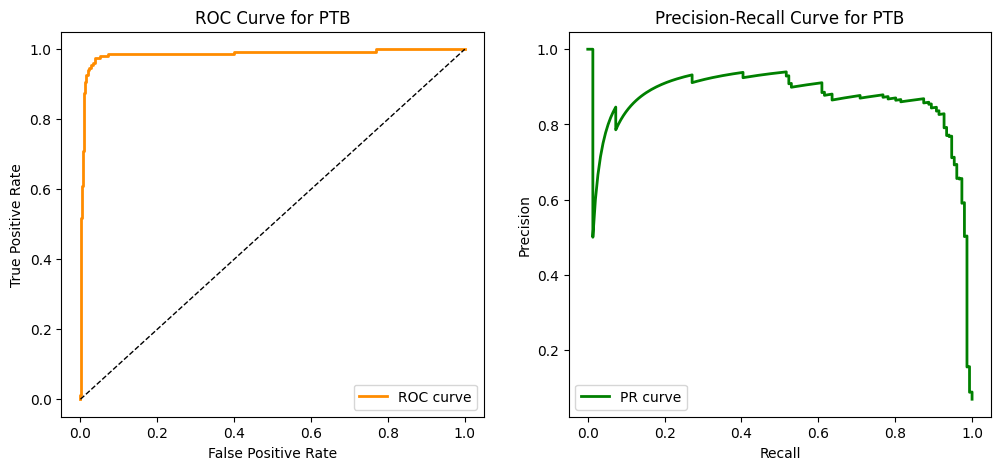

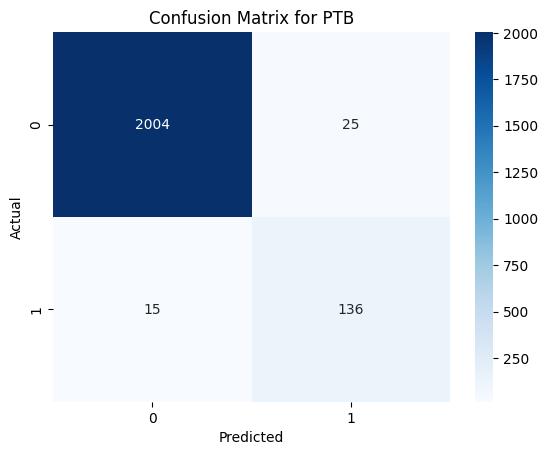

정밀도 (Precision): 0.8447
재현율 (Recall): 0.9007
F1 점수 (F1 Score): 0.8718


Testing SPH: 100%|██████████| 403/403 [00:03<00:00, 118.10it/s]


[SPH Test] AUROC: 0.9969 / AUPRC: 0.8629 / Accuracy: 99.18% / Loss: 0.0252


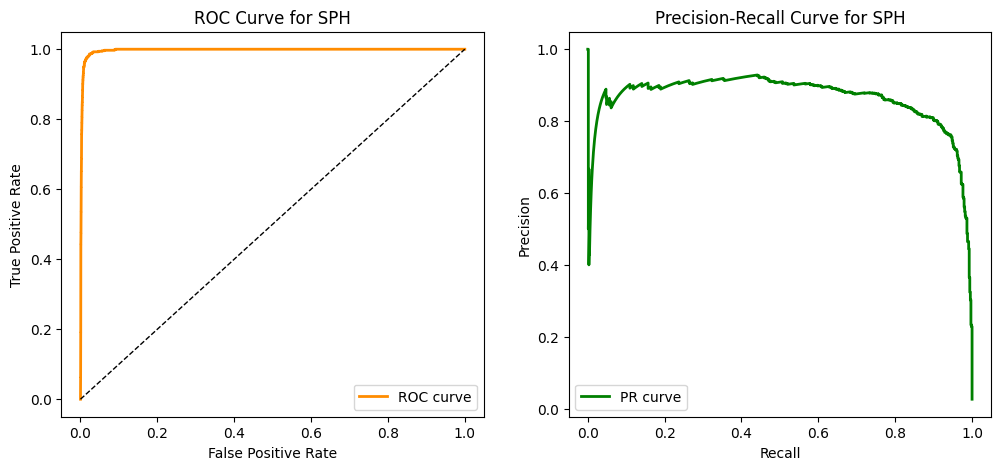

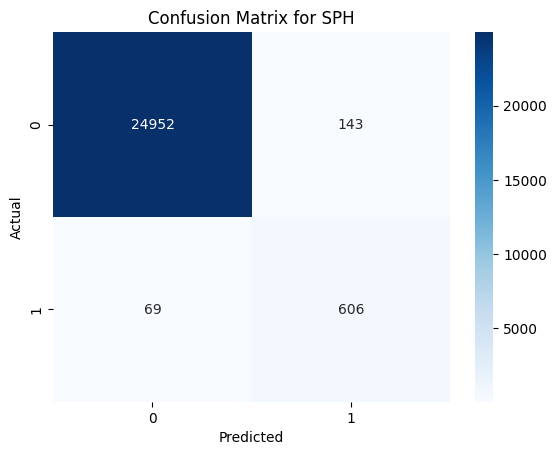

정밀도 (Precision): 0.8091
재현율 (Recall): 0.8978
F1 점수 (F1 Score): 0.8511


In [9]:
# 두 데이터셋을 함께 테스트
test_datasets(Custom1DCNN, 'Deep_best_model.pth')